# Week 4
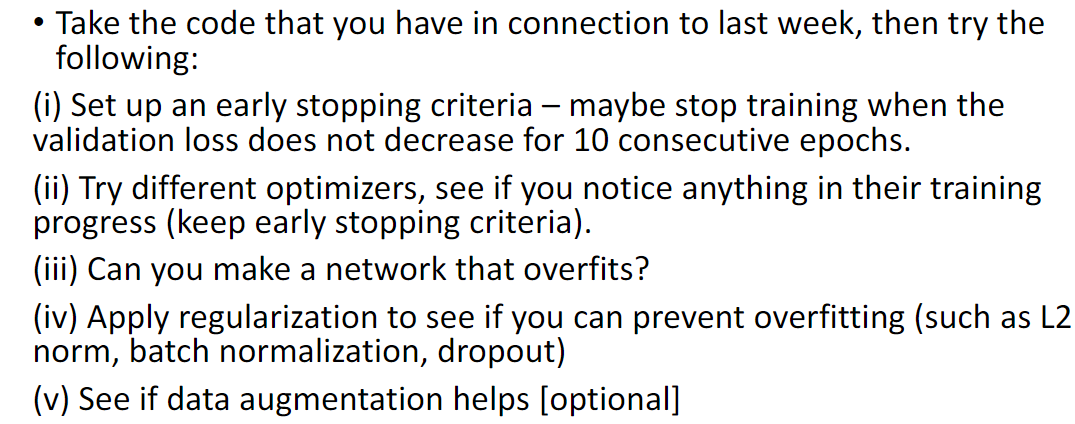

In [1]:
#Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary

#Sci-kit learn
import sklearn.model_selection

#Numpy
import numpy as np

#IPython
from IPython.display import clear_output

#Matplotlib
import matplotlib.pyplot as plt

#Dataset
from mlxtend.data import mnist_data



In [2]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

classes = training_data.classes
num_training_samples = len(training_data)
num_test_samples = len(test_data)

batch_size = 64 # we will talk about it later

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [3]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda" if torch.cuda.is_available()
     else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        #Convolutional Layers
        self.Conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,stride=1)
        self.Conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1)
        #Pooling Layers
        self.Pool = nn.MaxPool2d(kernel_size=2,stride=2)
        #Linear Layers
        self.Linear1 = nn.Linear(in_features=256,out_features=256)
        self.Linear2 = nn.Linear(in_features=256,out_features=120)
        self.Linear3 = nn.Linear(in_features=120,out_features=84)
        self.Linear4 = nn.Linear(in_features=84,out_features=10)

        #Activation Functions
        self.ReLU = nn.ReLU(inplace=True)

        #Flattening Function
        self.flatten = nn.Flatten()

        #Dropout Function
        self.dropout = nn.Dropout(p=0.1)
        self.dropout2d = nn.Dropout2d(p=0.2)

    def forward(self, x):
        x = self.Conv1(x)
        x = self.dropout2d(x)
        x = self.ReLU(x)
        x = self.Pool(x)
        x = self.Conv2(x)
        x = self.dropout2d(x)
        x = self.ReLU(x)
        x = self.Pool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.Linear1(x)
        x = self.ReLU(x)
        x = self.Linear2(x)
        x = self.ReLU(x)
        x = self.Linear3(x)
        x = self.ReLU(x)
        logits = self.Linear4(x)

        return logits

model = NeuralNetwork().to(device)


Using cuda device


In [5]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss, correct = 0, 0  # Track the total loss for the epoch

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)


        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        total_loss += loss.item()  # Accumulate loss

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Calculate accuracy
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        #if batch % 100 == 0:
        #    loss, current = loss.item(), (batch + 1) * len(X)
        #    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    avg_loss = total_loss / len(dataloader)  # Calculate average loss for the epoch
    avg_accuracy = correct / size

    train_losses.append(avg_loss)  # Store the average loss for the epoch
    train_accuracies.append(avg_accuracy) # Store the average accuracy for the epoch

    print(f"Train loss: {avg_loss:>7f}, Accuracy: {(100*avg_accuracy):>0.1f}%")

In [6]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    test_losses.append(test_loss)  # Store the test loss for the epoch
    test_accuracies.append(correct)

    print(f"Test Error: \n Avg loss: {test_loss:>8f}, Accuracy: {(100*correct):>0.1f}% \n")

In [7]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

model = NeuralNetwork().to(device)

learning_rate = 0.002

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Let's use stocastic gradient descent (We will talk about it in the coming weeks)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

epochs = 30
for t in range(epochs):
    eps = t+1
    if t % 4 == 0:
        clear_output(wait=True)
    print(f"Epoch {t+1}\n-------------------------------")
    print('lr = ',scheduler.get_last_lr())
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    scheduler.step()
    if t > 10:
        loss_var = np.var(test_losses[-10:-1])
        if loss_var < 0.001:
            print('Test loss has converged, breaking the loop')
            break
print("Done!")


Epoch 9
-------------------------------
lr =  [0.001]
Train loss: 0.044714, Accuracy: 98.6%
Test Error: 
 Avg loss: 0.029453, Accuracy: 99.0% 

Epoch 10
-------------------------------
lr =  [0.001]
Train loss: 0.043341, Accuracy: 98.6%
Test Error: 
 Avg loss: 0.032375, Accuracy: 99.0% 

Epoch 11
-------------------------------
lr =  [0.0005]
Train loss: 0.032738, Accuracy: 98.9%
Test Error: 
 Avg loss: 0.026709, Accuracy: 99.2% 

Epoch 12
-------------------------------
lr =  [0.0005]
Train loss: 0.030133, Accuracy: 99.0%
Test Error: 
 Avg loss: 0.026995, Accuracy: 99.2% 

Test loss has converged, breaking the loop
Done!


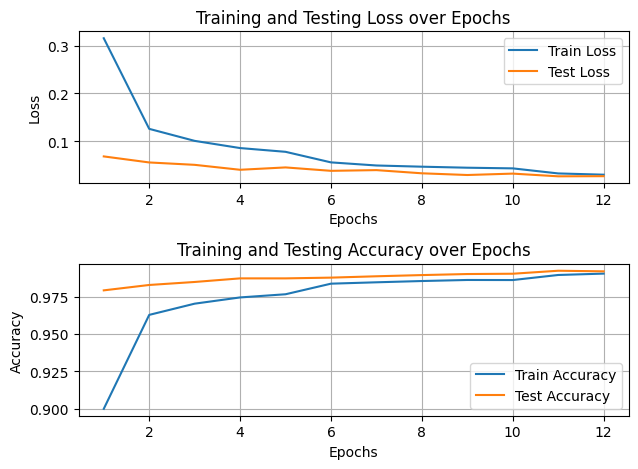

In [10]:
plt.subplot(2,1,1)
plt.plot(range(1, eps+1), train_losses, label="Train Loss")
plt.plot(range(1, eps+1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing Loss over Epochs")
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(range(1, eps+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, eps+1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Testing Accuracy over Epochs")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### prediction results for all images in the test set and show some examples where the predictions are wrong

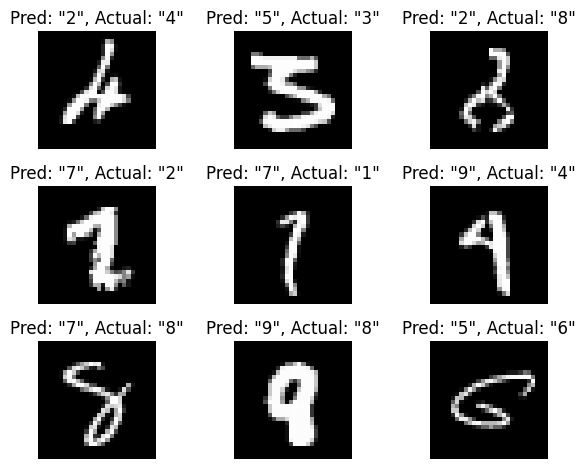

In [11]:
model.eval()
x = test_data.data.unsqueeze(0).float().permute(1,0,2,3)
x_c = x.squeeze()
y = test_data.targets
k = 1
#YOUR CODE HERE
with torch.no_grad():
    x_d = x.to(device)
    pred = model(x_d)
    predicted = torch.Tensor.cpu(pred.argmax(1)).numpy()
    actual = y.numpy()
    checker = predicted==actual
    for i in range(len(checker)):
        ax = plt.subplot(3,3,k)
        if checker[i]==False:
            k += 1
            ax.imshow(x_c[i],cmap='gray')
            ax.set_axis_off()
            ax.set_title(f'Pred: "{predicted[i]}", Actual: "{actual[i]}"')
            if k > 9:
                break
plt.tight_layout()

